In [1]:
import pandas as pd
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import face_recognition

In [2]:
dataset = 'dataset/datasets/'
images = glob.glob(dataset+"*/*")
np.random.shuffle(images)

In [3]:
data_face = []
label_face = []
for i in images:
    img = i
    lbl = img.split('/')[-2]
    label_face.append(lbl)
    image = face_recognition.load_image_file(i)
    face_locations = face_recognition.face_locations(image)
    try:
        (top, right, bottom, left) = face_locations[0]
        img_ = image[top:bottom, left:right, :]
        img_ = cv2.resize(img_, (100, 100))
        data_face.append(img_)
    except:
        print('Found error at ==> ', i)

Found error at ==>  dataset/datasets/cezar/17.jpg
Found error at ==>  dataset/datasets/cezar/14.jpg
Found error at ==>  dataset/datasets/cezar/5.jpg
Found error at ==>  dataset/datasets/cezar/13.jpg
Found error at ==>  dataset/datasets/zul/18.jpg
Found error at ==>  dataset/datasets/toufan/6.jpg
Found error at ==>  dataset/datasets/cezar/21.jpg
Found error at ==>  dataset/datasets/cezar/18.jpg
Found error at ==>  dataset/datasets/surahmin/15.png


In [4]:
face_flip = []
lbl_fl = []

In [5]:
for j, im in zip(data_face, images):
    for k in range(2):
        flip = cv2.flip(j, k)
        face_flip.append(flip)
        lbl_fl_o = im.split('/')[-2]
        lbl_fl.append(lbl_fl_o)

In [6]:
# final_aug_img = []
# final_aug_lbl = []
# for a, aa in zip(face_flip, lbl_fl):
#     (h, w) = a.shape[:2]
#     center = (h // 2, w // 2)
#     for deg in range(len(face_flip)):
#         M = cv2.getRotationMatrix2D(center, deg, 1.0)
#         rotated = cv2.warpAffine(a, M, (w, h))
#         final_aug_img.append(rotated)
#         final_aug_lbl.append(aa)

In [7]:
# print('x_train : ', np.shape(final_aug_img))
# print('y_train : ', np.shape(final_aug_lbl))

In [8]:
# import pickle
# f = open('face_image_aug.pickle', 'wb')
# f.write(pickle.dumps(final_aug_img))
# f.close()

In [9]:
# import pickle
# f = open('label_image_aug.pickle', 'wb')
# f.write(pickle.dumps(label_face))
# f.close()

In [10]:
data_x_test = []
data_y_test = []
for i in images:
    gbr = cv2.imread(i)
    gbr = cv2.resize(gbr, (100, 100))
    data_x_test.append(gbr)
    lbl_test = i.split('/')[-2]
    data_y_test.append(lbl_test)
x_test = np.array(data_x_test)
y_test = np.array(data_y_test)

In [11]:
print(x_test.shape)
print(y_test.shape)

(151, 100, 100, 3)
(151,)


In [12]:
x_train = np.array(face_flip)
y_train = np.array(lbl_fl)

In [13]:
print(x_train.shape)
print(y_train.shape)

(284, 100, 100, 3)
(284,)


In [14]:
x_train = np.float32(x_train) / 255
x_test = np.float32(x_test) / 255

In [15]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_en = lb.fit_transform(y_train)
y_test_en = lb.transform(y_test)

In [16]:
# y_tst

In [17]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y_en, test_size=0.25, random_state=42)
# # cek apakah sudah benar atau belum pemecaannya
# print('x_train : ',x_train.shape)
# print('x_test  : ', x_test.shape)
# print('y_train : ', y_train.shape)
# print('y_test  : ', y_test.shape)

In [18]:
# # keras model
# from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
# from keras.models import Input, Model, Sequential
# # mulai membuat arsitektur NN dengan tipe fully connected layer
# from keras.layers import BatchNormalization, Dropout
# input_layer    = Input(shape=(x_train.shape[1:]))

# batch = BatchNormalization(input_shape=x_train.shape[1:])(input_layer)
# conv = Conv2D(16, kernel_size=(5,5), padding='SAME', activation='relu', name='conv_layer_1')(batch)
# pool = MaxPool2D(pool_size=(4,4), name='maxpooling_1')(conv)
# drop = Dropout(0.25)(pool)

# batch1 = BatchNormalization(input_shape=x_train.shape[1:])(drop)
# conv1 = Conv2D(16, kernel_size=(5,5), padding='SAME', activation='relu', name='conv_layer_2')(batch1)
# pool1 = MaxPool2D(pool_size=(4,4), name='maxpooing_2')(conv1)
# drop1 = Dropout(0.25)(pool1)

# flatten_layer = Flatten(name='flatten_layer')(drop1)
# full_con_layer = Dense(512, activation='relu', name='fully_connected_layer')(flatten_layer)
# full_con_layer1 = Dense(128, activation='relu', name='fully_connected_layer_1')(full_con_layer)
# drop3 = Dropout(0.5)(full_con_layer1)
# output_layer = Dense(6, activation='softmax', name='output_layer')(drop3)
# model = Model(inputs=input_layer, outputs=output_layer)
# # model.summary()

In [19]:
  # keras model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling2D, Activation
from keras.models import Input, Model, Sequential

leaky = 'relu'

input_layer = Input(shape=x_train.shape[1:])
batch0 = BatchNormalization()(input_layer)
conv0 = Conv2D(filters=16, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch0)
max1 = MaxPool2D(pool_size=(2,2), strides=2)(conv0)

batch2 = BatchNormalization()(max1)
conv2 = Conv2D(filters=32, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch2)
max3 = MaxPool2D(pool_size=(2,2), strides=2)(conv2)

batch4 = BatchNormalization()(max3)
conv4 = Conv2D(filters=16, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(batch4)

batch5 = BatchNormalization()(conv4)
conv5 = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch5)

batch6 = BatchNormalization()(conv5)
conv6 = Conv2D(filters=16, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(batch6)

batch7 = BatchNormalization()(conv6)
conv7 = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch7)

max8 = MaxPool2D(pool_size=(2,2), strides=2)(conv7)

batch9 = BatchNormalization()(max8)
conv9 = Conv2D(filters=32, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(batch9)

batch10 = BatchNormalization()(conv9)
conv10 = Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch10)

batch11 = BatchNormalization()(conv10)
conv11 = Conv2D(filters=32, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(conv10)

batch12 = BatchNormalization()(conv11)
conv12 = Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch12)

max13 = MaxPool2D(pool_size=(2,2), strides=2)(conv12)

batch14 = BatchNormalization()(max13)
conv14 = Conv2D(filters=64, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(batch14)

batch15 = BatchNormalization()(conv14)
conv15 = Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch15)

batch16 = BatchNormalization()(conv15)
conv16 = Conv2D(filters=64, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(batch16)

batch17 = BatchNormalization()(conv16)
conv17 = Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=leaky, padding='SAME')(batch17)

batch18 = BatchNormalization()(conv17)
conv18 = Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(batch18)

batch19 = BatchNormalization()(conv18)
conv19 = Conv2D(filters=2, kernel_size=(1,1), strides=1, activation=leaky, padding='SAME')(batch19)

avg = AveragePooling2D()(conv19)
flat = Flatten()(avg)
fc = Dense(6)(flat)
output_layer = Activation(activation='sigmoid')(fc)
model = Model(inputs=input_layer, outputs=output_layer)

Using TensorFlow backend.


In [20]:
import shutil
file_tensorboard = 'tboard'
shutil.rmtree(file_tensorboard+'/')

In [21]:
import keras
from keras.callbacks import ReduceLROnPlateau
Tensorboard = keras.callbacks.TensorBoard(log_dir='./'+file_tensorboard, histogram_freq=1,  write_graph=True, write_images=False)

# Save the checkpoint in the /output folder
# filepath = "/keras-ckpt/mnist-cnn-best.hdf5"

# # Keep only a single checkpoint, the best over test accuracy.
# checkpoint = keras.callbacks.ModelCheckpoint(filepath,
#                             monitor='val_acc',
#                             verbose=1,
#                             save_best_only=True,
#                             mode='max')

from keras.optimizers import SGD
opt = SGD(lr=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [22]:
history = model.fit(x_train, y_train_en, 
                    batch_size=64, epochs=100,
                   validation_data=[x_test, y_test_en], 
                    callbacks=[Tensorboard, reduce_lr])
model.save('face_recognition_model.h5')

Train on 284 samples, validate on 151 samples
Epoch 1/100
284/284 [==============================] - 7s 24ms/step - loss: 1.9151 - acc: 0.1514 - val_loss: 4.8655 - val_acc: 0.1192
Epoch 2/100
284/284 [==============================] - 3s 11ms/step - loss: 1.7570 - acc: 0.2359 - val_loss: 4.6288 - val_acc: 0.1523
Epoch 3/100
284/284 [==============================] - 3s 11ms/step - loss: 1.5939 - acc: 0.3345 - val_loss: 3.3134 - val_acc: 0.1722
Epoch 4/100
284/284 [==============================] - 3s 11ms/step - loss: 1.4326 - acc: 0.4542 - val_loss: 3.7666 - val_acc: 0.1854
Epoch 5/100
284/284 [==============================] - 3s 11ms/step - loss: 1.2405 - acc: 0.5669 - val_loss: 4.2713 - val_acc: 0.1987
Epoch 6/100
284/284 [==============================] - 3s 11ms/step - loss: 1.0574 - acc: 0.6690 - val_loss: 4.6483 - val_acc: 0.1656
Epoch 7/100
284/284 [==============================] - 3s 12ms/step - loss: 0.9319 - acc: 0.6937 - val_loss: 3.9574 - val_acc: 0.1921
Epoch 8/100
284/

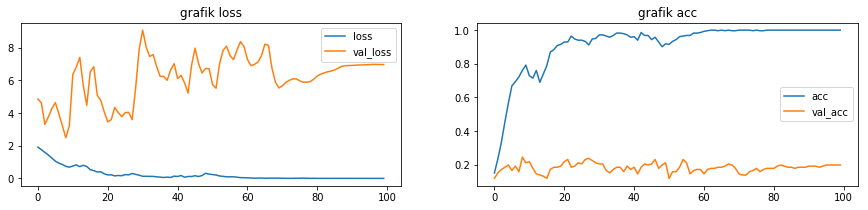

In [24]:
# nilai-nilai loss-nya
loss = history.history['loss']

# nilai-nilai val_loss-nya
val_loss = history.history['val_loss']

# nilai-nilai akurasi-nya
acc = history.history['acc']

# nilai-nilai val_acc-nya
val_acc = history.history['val_acc']

# menentukan sumbu x nya dari 0 sampai dengan banyaknya jumlah nilai loss/acc
sumbu_x = np.arange(0, len(loss))

# memasukan library plotting (matplotlib)
import matplotlib.pyplot as plt

# grafik plot untuk melihat loss
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.title('grafik loss')
plt.plot(sumbu_x, loss, label='loss')
plt.plot(sumbu_x, val_loss, label='val_loss')
plt.legend()

# grafik plot untuk melihat akurasinya
plt.subplot(1,2,2)
plt.title('grafik acc')
plt.plot(sumbu_x, acc, label='acc')
plt.plot(sumbu_x, val_acc, label='val_acc')
plt.legend()
plt.show()

In [37]:
loss_train, acc_train = model.evaluate(x_train, y_train_en)
print('loss_train :', round(loss_train, 5))
print('acc_train  : %.2f' % (acc_train * 100))
loss_test, acc_test = model.evaluate(x_test, y_test_en)
print('loss_test :', round(loss_test, 5))
print('acc_test  : %.2f' % (acc_test * 100))

284/284 [==============================] - 1s 2ms/step
loss_train : 0.00031
acc_train  : 100.00
151/151 [==============================] - 0s 2ms/step
loss_test : 6.9768
acc_test  : 19.87
